In [1]:
import json
import numpy as np
from numpy.fft import fft,ifft

import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.colors import BoundaryNorm
from matplotlib.ticker import MaxNLocator,LogLocator,MultipleLocator,AutoMinorLocator
from matplotlib.dates import SecondLocator,AutoDateFormatter
from matplotlib.ticker import PercentFormatter,ScalarFormatter
import matplotlib.dates as mdates
import matplotlib.ticker as mtick



from mpl_toolkits.mplot3d.axes3d import get_test_data
import pprint
from scipy import stats
from scipy.stats import binom
import datetime
import iso8601
import csv
import re
import math



In [2]:
#--- data was collected using the following
#--- tshark -T fields -e frame.time_epoch -e ipv6.dst -E separator=, -E quote=d   -Y 'udp contains 06:0f:2b:06:01:02' udp dst port 161 >pdus.csv
#pktdata = pd.read_csv('snmp-05072024.csv')
pktdata = pd.read_csv('snmp-smaller.csv')



In [3]:
#--- create summary of data as 1 second interval buckets per IP,per Timestamp
pktdata['Time'] = pd.to_datetime(pktdata['Time'],unit='s')
df = pd.DataFrame({'count': pktdata.groupby(['Time','IP']).size()}).reset_index()

display(df)

summary = (df.groupby(['IP', pd.Grouper(key='Time', freq='250ms')]).agg('count'))
summary.reset_index(inplace=True)
summary.set_index('Time', drop=False, inplace=True)
#summary

numIP = len(pd.unique(df['IP']))

print("Num IPs: ",numIP)

,Time,IP,count
0,2024-05-07 22:12:00.003170048,1,1
1,2024-05-07 22:12:00.003972096,1,1
2,2024-05-07 22:12:00.004769024,1,1
3,2024-05-07 22:12:00.010607104,1,1
4,2024-05-07 22:12:00.020504064,2,1
...,...,...,...
19054483,2024-05-09 19:39:06.718413056,73,1
19054484,2024-05-09 19:39:06.746872064,67,1
19054485,2024-05-09 19:39:06.834078976,73,1
19054486,2024-05-09 19:39:06.951499008,73,1


Num IPs:  77


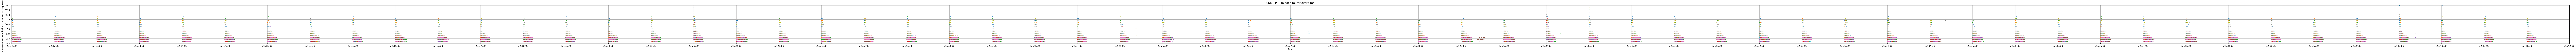

In [4]:
#--- create a simple scatter plot for each router
fig = plt.figure(figsize=(200,3))
ax = fig.add_subplot(1,1,1)

xmin = summary['Time'].min()
xmax = summary['Time'].max()

# Round to nearest years.
datemin = np.datetime64(xmin, '30s')
#datemax = np.datetime64(xmax,'1m')
#-- just peek at initial part of time
datemax = datemin + np.timedelta64(30, 'm')
ax.set_xlim(datemin, datemax)
ax.set_ylim(0,20)

list = summary['IP'].unique()
for ip in list:
  target = summary[summary['IP']==ip]
  plt.plot(target['count'],'.',ms=3, linewidth=0, )
   
plt.title('SNMP PPS to each router over time')
plt.xlabel('Time')
plt.ylabel('SNMP PPS/Router (each dot is a router at a given second)')


ax.xaxis.set_major_locator(SecondLocator(interval=30))
ax.grid(True)
plt.show()
  


In [5]:
#--- ok now lets come up with a few derived metrics for each poll cycle
#---   end time, elapsed time

#--- first we need to resample this data so we can buckets for all time slots for all routers
pd.options.mode.copy_on_write = True
df = summary.groupby('IP').resample('250ms').aggregate({'count':'sum'})
#df = summary.groupby('IP').aggregate({'count':'sum'})
display(df)

df.reset_index(inplace=True)
df.set_index('Time', drop=False, inplace=True)

newsum = pd.DataFrame()

list = df['IP'].unique()
id=0
for ip in list:
  #--- there is probably a smarter way to do this, but Im just adapting code 
  target = df[df['IP']==ip]  
        
  target.loc[target['count'] > 0,'active'] = 1
  target.loc[target['count'] == 0,'active'] = 0    
  target['start'] = target.active.ne(target['active'].shift())
  target['poll_id'] = target['start'].cumsum()
  target['id'] = id
  #--- remove times where nothing happened
  target = target[target.active == True]

  newsum = pd.concat([newsum,target])
    
  id+=1
  #display(target)

    
#display(newsum)   

    
summary2 = newsum.groupby(['id','poll_id']).agg(
    start=pd.NamedAgg(column='Time',aggfunc="min"),
    end  =pd.NamedAgg(column='Time',aggfunc="max"),
    count=pd.NamedAgg(column='count',aggfunc="sum")
)
summary2['et'] = (summary2['end'] - summary2['start']).dt.total_seconds()
summary2.reset_index(inplace=True)
df.set_index('IP', drop=False, inplace=True)

summary2
#pd.set_option('display.max_rows',None)

count
IP Time                          
1  2024-05-07 22:12:00.000     14
   2024-05-07 22:12:00.250     13
   2024-05-07 22:12:00.500     13
   2024-05-07 22:12:00.750     12
   2024-05-07 22:12:01.000      4
...                           ...
77 2024-05-09 19:39:05.000      3
   2024-05-09 19:39:05.250      1
   2024-05-09 19:39:05.500      2
   2024-05-09 19:39:05.750      3
   2024-05-09 19:39:06.000      1

[50395991 rows x 1 columns]

,id,poll_id,start,end,count,et
0,0,1,2024-05-07 22:12:00.000,2024-05-07 22:12:01.000,56,1.00
1,0,3,2024-05-07 22:12:30.000,2024-05-07 22:12:31.000,56,1.00
2,0,5,2024-05-07 22:13:00.000,2024-05-07 22:13:01.000,56,1.00
3,0,7,2024-05-07 22:13:30.000,2024-05-07 22:13:31.000,56,1.00
4,0,9,2024-05-07 22:14:00.000,2024-05-07 22:14:01.000,56,1.00
...,...,...,...,...,...,...
441796,76,19495,2024-05-09 19:37:30.000,2024-05-09 19:37:36.000,56,6.00
441797,76,19497,2024-05-09 19:38:00.000,2024-05-09 19:38:01.250,14,1.25
441798,76,19499,2024-05-09 19:38:01.750,2024-05-09 19:38:06.000,42,4.25
441799,76,19501,2024-05-09 19:38:30.000,2024-05-09 19:38:37.000,56,7.00


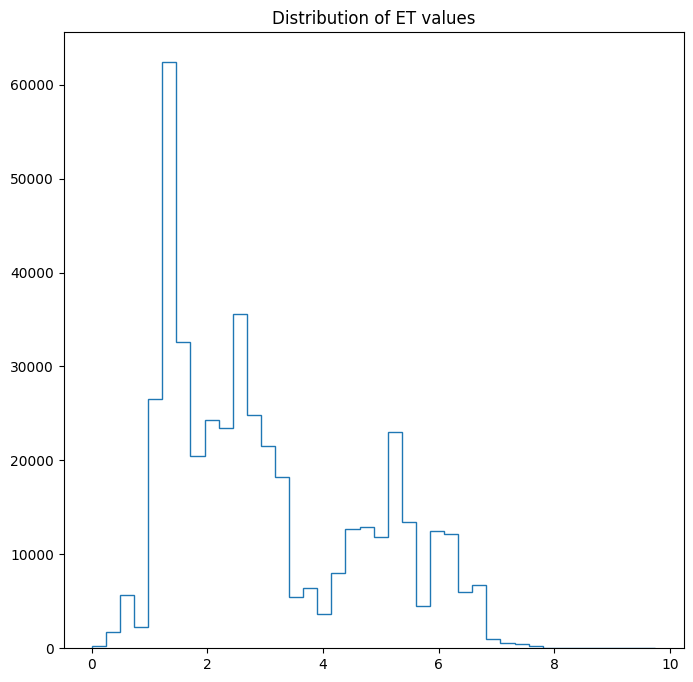

In [6]:
#summary2.boxplot(column='et',figsize=(1,5),grid=False)
#summary2.boxplot(column='et',by='id',figsize=(30,6),grid=False)


f,(ax1) = plt.subplots(nrows=1,ncols=1,figsize=(8,8))#,gridspec_kw={'width_ratios':[5,5]})
ax1.hist(summary2['et'],bins=40,density=False,cumulative=False,histtype='step')  
ax1.set_title('Distribution of ET values')
plt.yscale('linear')
#ax3.set_title('Rate')
#ax4.plot(summary2['start'],summary2['et'], '.',ms=1,linewidth=0,color='grey')
#ax4.set_title('Poll ET')
    #ax4.xaxis.set_major_locator(SecondLocator(bysecond=[0,60*60*24]))
    #f.suptitle('var='+str((tv))
plt.show()







77

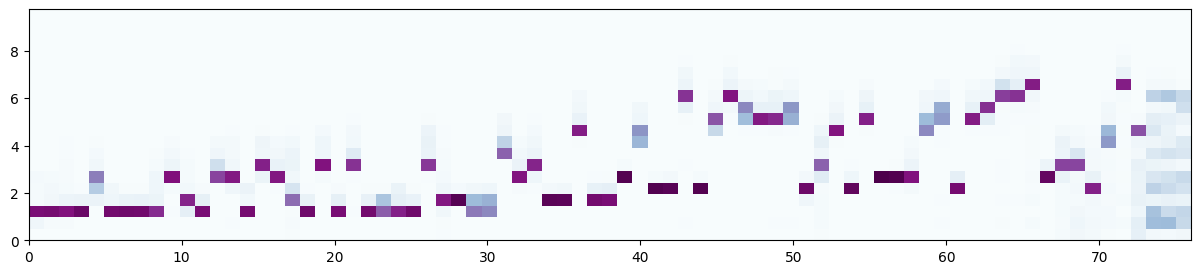

In [7]:
#---- now lets plot
fig = plt.figure(figsize=(15,3))
axs = fig.add_subplot(111)#,projection='3d')
#axs.view_init(elev=90,azim=0)
#fig, axs = plt.subplots(1, 1, figsize=(5, 15), sharex=True, sharey=True,
#                       projection='3d')

sz = len(summary2['id'].unique())
display(sz)
hist,xedges,yedges = np.histogram2d(summary2['id'],summary2['et'],bins=sz)
# Construct arrays for the anchor positions of the 16 bars.
# Note: np.meshgrid gives arrays in (ny, nx) so we use 'F' to flatten xpos,
# ypos in column-major order. For numpy >= 1.7, we could instead call meshgrid
# with indexing='ij'.
xpos, ypos = np.meshgrid(xedges[:-1] + 0.25, yedges[:-1] + 0.25)
xpos = xpos.flatten('F')
ypos = ypos.flatten('F')
zpos = np.zeros_like(xpos)

# Construct arrays with the dimensions for the 16 bars.
dx = 0.5 * np.ones_like(zpos)
dy = dx.copy()
dz = hist.flatten()


cmap = cm.get_cmap('jet') # Get desired colormap - you can change this!
max_height = np.max(dz)   # get range of colorbars so we can normalize
min_height = np.min(dz)
# scale each z to [0,1], and get their rgb values
rgba = [cmap((k-min_height)/max_height) for k in dz] 
#axs.bar3d(xpos, ypos, zpos, 1, 1,dz,color=rgba, zsort='average')

axs.hist2d(summary2['id'],summary2['et'],bins=(sz,20),cmap=plt.cm.BuPu)
plt.show()


Looking at the root of the issue:
- When there is signficant varience between adjecent measurements this will cause errors in rate cal
- we want to understand how often there are errors and what is the magnitude of those errors
- assume the following model
  - every 30 seconds a router updates its counters in the MIB
  - if poll ET is long say 6 seconds, as long as its consistently long and the order of execution is consistent on the collector, one can assume error will be minimal
  - When ET changes signficantly between Poll-1 and Poll-2, there is a chance that both of the following will happen
    - counters at the beginning of a polly cycle (lower index values) will have have been collected much sooner than the stated timestamp, causing  rate overshoot
    - counters at the end of the poll cycle (higher index values) will have been collected close to the stated timestamp, causing minimal rate overshoot
    
- imagine a case where we are running at 100Gbps on a port with a low index... thats 100,000,000,000 bps or 3,000,000,000,000 bits in 30 second poll interval
- if p0 takes 1 second longer than p1, this will result in an observed poll interval of 29 seconds == 103.45Gbps or 3.3% error
     
first thing we need to do is derive the delta between adjacent polls

/tmp/ipykernel_97591/526846577.py:3: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for x,y in summary2.groupby(by=['id']):


<AxesSubplot: title={'center': 'et_delta'}, xlabel='id'>

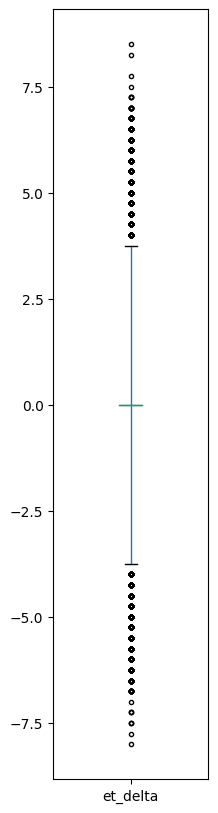

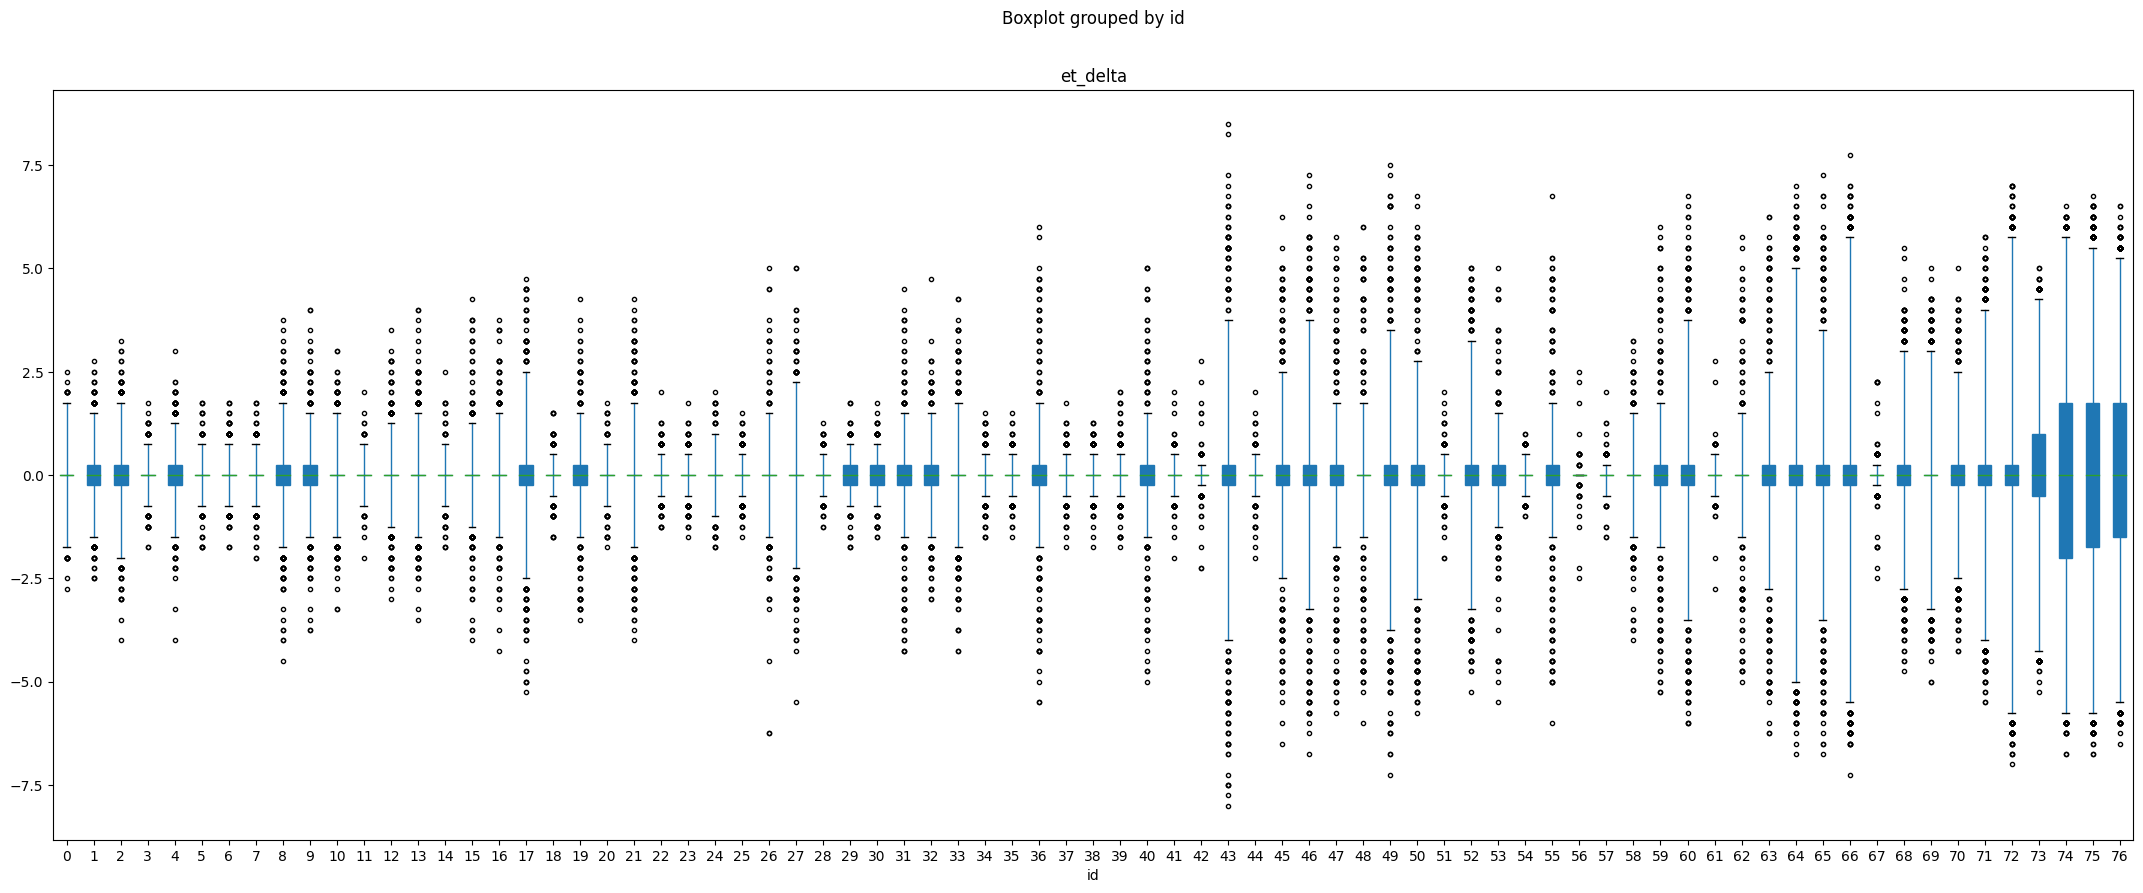

In [8]:
#--- now lets look for varience in et bewtween T(n) and T(n+1)
summary3 = pd.DataFrame()
for x,y in summary2.groupby(by=['id']):
  y['et_delta'] = y['et'].shift() - y['et']
  summary3= pd.concat([summary3,y])

summary3.boxplot(column='et_delta',figsize=(2,10),grid=False,backend='matplotlib',patch_artist=True,sym='.',whis=[1,99])

summary3.boxplot(column='et_delta',by='id',figsize=(26,10),grid=False,backend='matplotlib',patch_artist=True,sym='.',whis=[1,99])





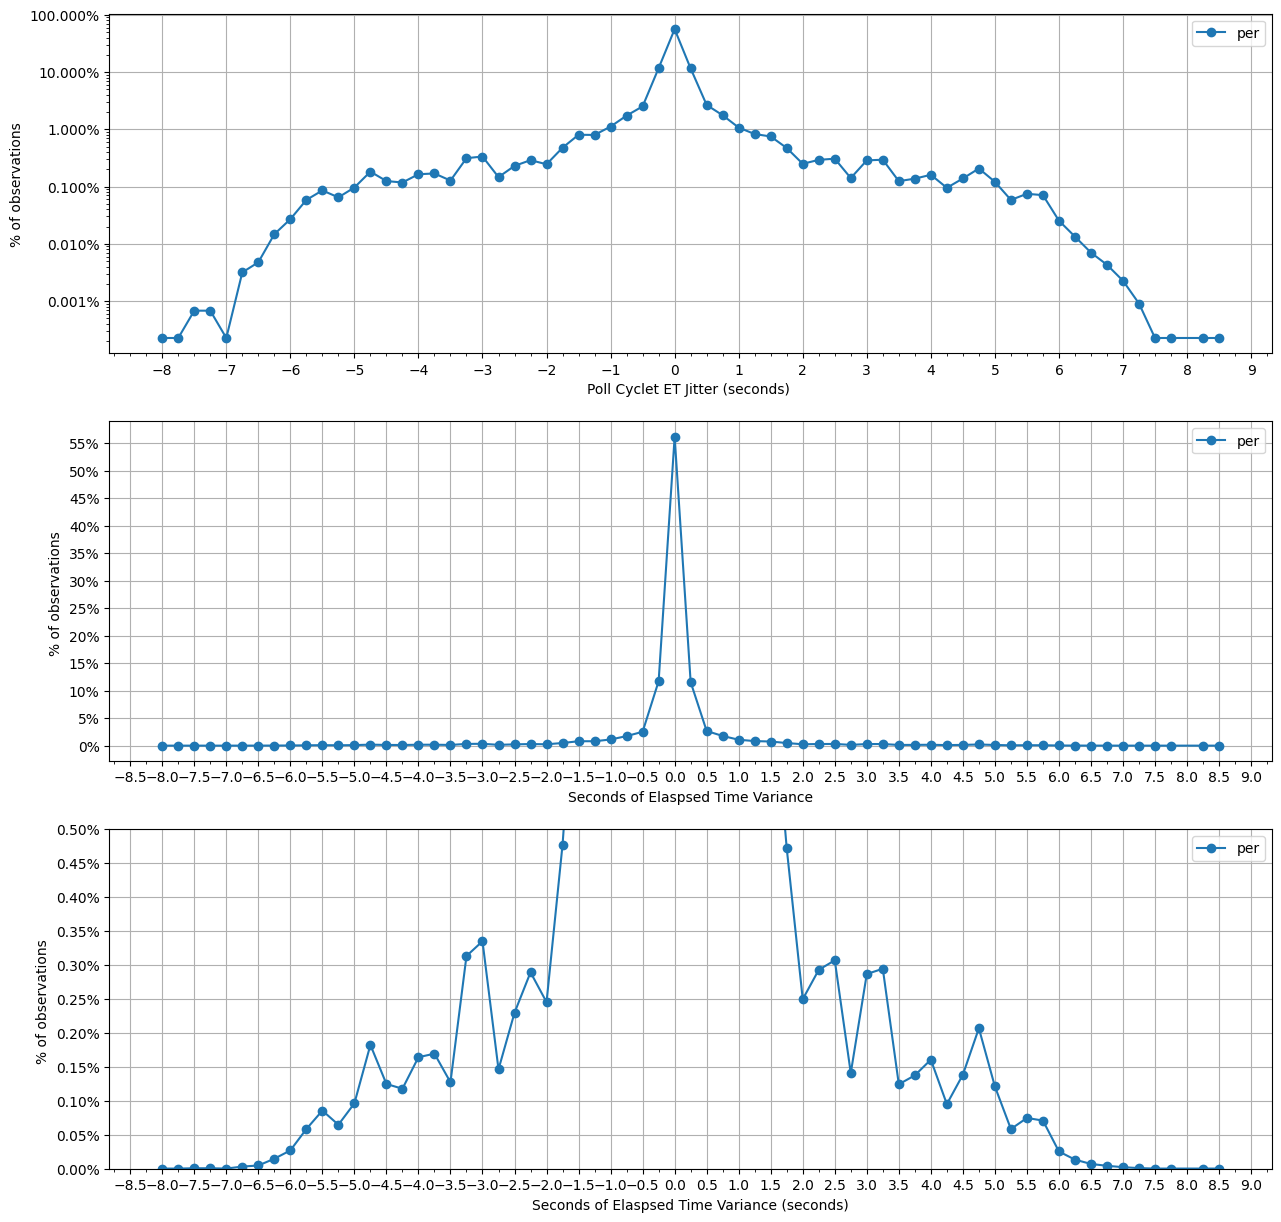

et_delta stdev: 4.812088083664068
et_delta mean: 0.13257575757575757
25%tile: -3.9375
75%tile: 4.1875


In [9]:
#--- calculate the distribution of Elapsed Time Variance as a percentage of all observations

dist = summary3.value_counts(subset=['et_delta'],sort=False,normalize=True).to_frame('per')

dist.reset_index(inplace=True)

#display(summary3.value_counts())

fig,[ax,ax2,ax3] = plt.subplots(3,figsize=(15,15))
ax.set_yscale('log')

dist.plot(kind='line',marker='o',x='et_delta',y='per',ax=ax)

ax.xaxis.set_major_locator(MultipleLocator(1))
ax.xaxis.set_minor_locator(MultipleLocator(.25))
#ax.yaxis.set_major_locator(MultipleLocator(.05))
#ax.yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
ax.yaxis.set_major_formatter(mtick.PercentFormatter(1.0,decimals=3))

ax.grid(True)
#ax.set_xlim(-10,10)
#ax.set_ylim(0,.75)
ax.set_ylabel("% of observations")
ax.set_xlabel("Poll Cyclet ET Jitter (seconds) ")
#plt.show()

dist.plot(kind='line',marker='o',x='et_delta',y='per',ax=ax2)
#ax.xaxis.set_units(secs)
#ax.set_yscale("symlog",linthresh=0.001)
ax2.xaxis.set_major_locator(MultipleLocator(.5))
ax2.xaxis.set_minor_locator(MultipleLocator(.25))
ax2.yaxis.set_major_locator(MultipleLocator(.05))
ax2.yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
ax2.grid(True)
#ax2.set_xlim(-10,10)
#ax2.set_ylim(0,.04)
ax2.set_ylabel("% of observations ")
ax2.set_xlabel("Seconds of Elaspsed Time Variance")

dist.plot(kind='line',marker='o',x='et_delta',y='per',ax=ax3)
#ax.xaxis.set_units(secs)
#ax.set_yscale("symlog",linthresh=0.001)
ax3.xaxis.set_major_locator(MultipleLocator(.5))
ax3.xaxis.set_minor_locator(MultipleLocator(.25))
ax3.yaxis.set_major_locator(MultipleLocator(.0005))
ax3.yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
ax3.grid(True)
#ax3.set_xlim(-10,10)
ax3.set_ylim(0,.005)
ax3.set_ylabel("% of observations ")
ax3.set_xlabel("Seconds of Elaspsed Time Variance (seconds)")


plt.show()

stdev = dist['et_delta'].std(ddof=1)
mean  = dist['et_delta'].mean()

print ("et_delta stdev: "+str(stdev))
print ("et_delta mean: "+str(mean))

print ('25%tile: '+str(dist['et_delta'].quantile(.25)))
print ('75%tile: '+str(dist['et_delta'].quantile(.75)))

